# practice 2. chi-square test 

이번 챕터에서는 실제 게임 회사에서 실시한 AB 테스트를 가지고 EDA 작업과 t-test, 카이 제곱 검정을 진행해보겠습니다.

데이터 셋 출처: https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats

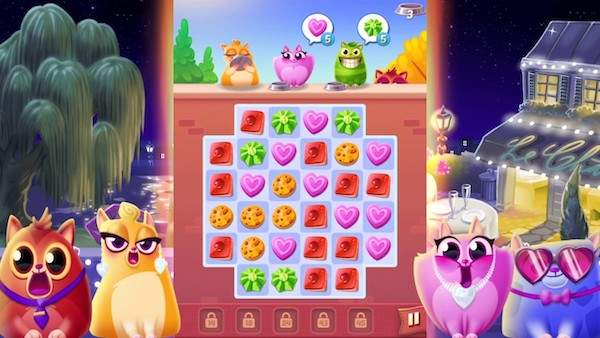

cookie cats는 모바일 퍼즐 게임입니다. 게임을 플레이하다보면 유저들은 게이트를 만납니다. 게이트를 만나면 유저는 꽤 오랜 시간을 기다리거나 결제를 해야만 합니다. 

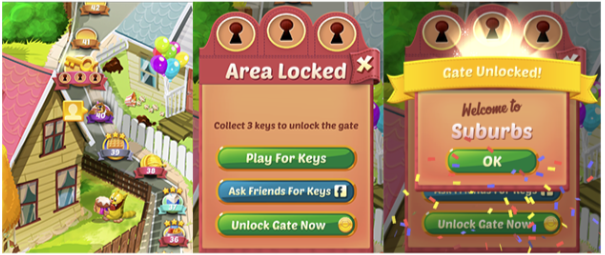

In [1]:
# A,B테스트
# 회사가 일정 난이도, 30 스테이지까지는 무료로 하다가 그 이후부터는 기다리거나 돈을 내거나
# 30애서 40단계로 올리면 유저들의 retention을 늘지 않을까?
# 하나의 그룹에서는 30스테이지 깨고 나서 잠금 화면 보여주고 다른 그룹한테는 40스테이지 이후에 잠금 화면 보여주기
# 다른 조건은 다 유지하는데 하나의 조건만 바꿔서 두 그룹한테 테스트하기

이 AB 테스트는 유저가 첫번째 게이트에 도달하는 시점을 30 라운드에서 40 라운드로 옮겼을 때, 리텐션에 어떤 변화가 있는지를 테스트 한 데이터입니다.  유저들은 무작위로 gate_30 혹은 gate_40 그룹에 할당되었습니다. 그리고 설치 후 1일 뒤에도 다시 접속했는지(retention 1), 설치 후 7일 뒤에도 다시 접속했는지 여부(retention 7)를 측정하였습니다.

### 요구사항
- 기본적인 EDA와 전처리를 진행하세요
- t-test를 이용하여 gate_30 그룹과 gate_40 그룹의 플레이 라운드 수의 평균이 같은지, 다른지 검정하세요.
- chi_squre test를 이용하여 version과 retention_1이 서로 독립인지 검정하세요.
- chi_squre test를 이용하여 version과 retention_2이 서로 독립인지 검정하세요.
- 검정 결과를 해석하고, AB 테스트의 결론을 내려보세요.

# 데이터 불러오기

In [115]:
import pandas as pd

In [116]:
df = pd.read_csv("./data/cookie_cats.csv")

In [117]:
df.shape

(90189, 5)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [119]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [120]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [121]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# 데이터 전처리

In [122]:
# id는 냅두고
# version label encoding?
# sum_gamerounds = 연속형 데이터
# retention = label encoding?
# sum_gamerounds 는 연속형 

In [123]:
import sklearn
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [124]:
# label encoding - version ( gate_30 = 0, gate_40 = 1 )
# df["which_version"] = label_encoder.fit_transform(df["version"])

In [125]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [127]:
# label encoding - retention_1 ( False = 0, True = 1 )
df["ret_01"] = label_encoder.fit_transform(df["retention_1"])

In [128]:
# label encoding - retention_1 ( False = 0, True = 1 )
df["ret_07"] = label_encoder.fit_transform(df["retention_7"])

In [129]:
#df.drop(["retention_1", "retention_7"], axis= 1)

In [130]:
df["ret_sum"] =  df["ret_01"] + df["ret_07"]

In [131]:
df

,userid,version,sum_gamerounds,retention_1,retention_7,ret_01,ret_07,ret_sum
0,116,gate_30,3,False,False,0,0,0
1,337,gate_30,38,True,False,1,0,1
2,377,gate_40,165,True,False,1,0,1
3,483,gate_40,1,False,False,0,0,0
4,488,gate_40,179,True,True,1,1,2
...,...,...,...,...,...,...,...,...
90184,9999441,gate_40,97,True,False,1,0,1
90185,9999479,gate_40,30,False,False,0,0,0
90186,9999710,gate_30,28,True,False,1,0,1
90187,9999768,gate_40,51,True,False,1,0,1


In [61]:
#df = df[df['sum_gamerounds'] != max(df['sum_gamerounds'])]

In [132]:
df = df[df['sum_gamerounds'] < 40000]

In [133]:
df.describe()

,userid,sum_gamerounds,ret_01,ret_07,ret_sum
count,9.018800e+04,90188.000000,90188.000000,90188.000000,90188.000000
mean,4.998397e+06,51.320253,0.445214,0.186056,0.631270
std,2.883298e+06,102.682719,0.496992,0.389154,0.724636
min,1.160000e+02,0.000000,0.000000,0.000000,0.000000
25%,2.512211e+06,5.000000,0.000000,0.000000,0.000000
50%,4.995804e+06,16.000000,0.000000,0.000000,0.000000
75%,7.496461e+06,51.000000,1.000000,0.000000,1.000000
max,9.999861e+06,2961.000000,1.000000,1.000000,2.000000


# EDA

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt

In [21]:
df.groupby('version')["sum_gamerounds"].count()

version
gate_30    44700
gate_40    45489
Name: sum_gamerounds, dtype: int64

<Axes: >

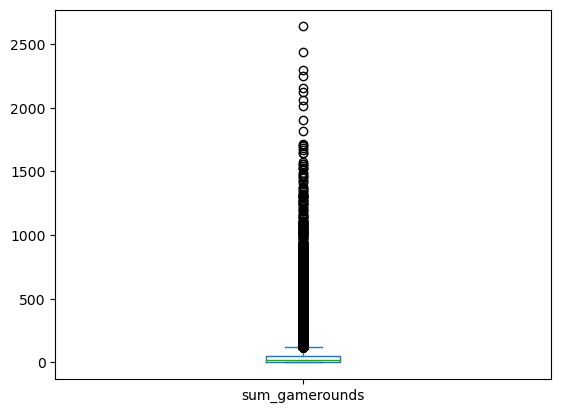

In [64]:
df["sum_gamerounds"].plot(kind="box")

<Axes: xlabel='version', ylabel='count'>

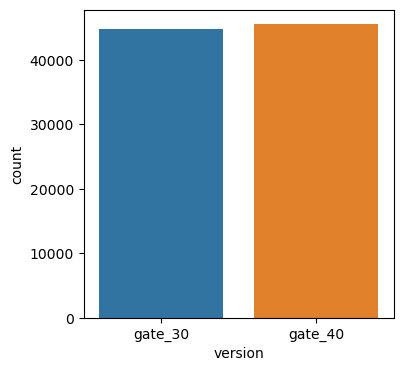

In [65]:
plt.figure(figsize=(4,4))
sns.countplot(x='version',  data=df)

In [66]:
#This countplot will give you a visual representation of the number of observations for each version.

<Axes: xlabel='version'>

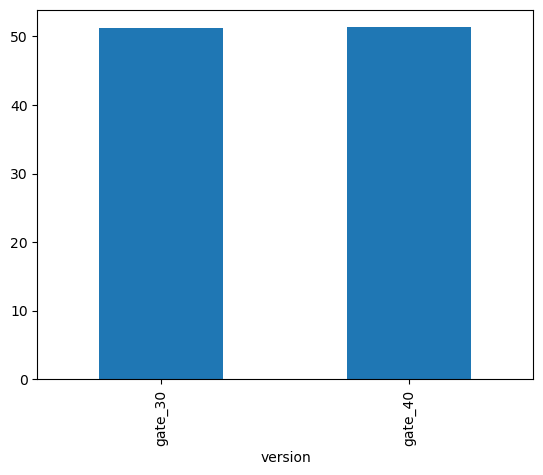

In [67]:
df.groupby("version")["sum_gamerounds"].mean().plot(kind="bar")

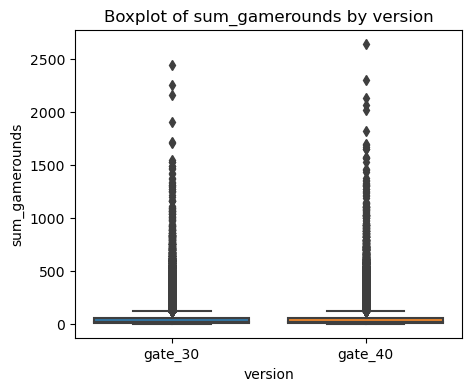

In [68]:
plt.figure(figsize=(5, 4))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.title('Boxplot of sum_gamerounds by version')
plt.show()

In [27]:
#This will show you the distribution of 'sum_gamerounds' for each version, 
#helping you identify any differences in the player engagement between the two versions.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


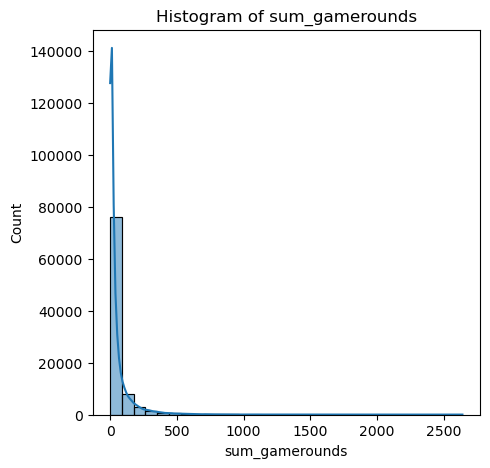

In [69]:
plt.figure(figsize=(5, 5))
sns.histplot(df['sum_gamerounds'], bins=30, kde=True)
plt.title('Histogram of sum_gamerounds')
plt.show()

In [33]:
#This will show you the distribution of 'sum_gamerounds' across all observations.

In [91]:
df.groupby("version")["retention_1"].value_counts()

version  retention_1
gate_30  False          24665
         True           20033
gate_40  False          25370
         True           20119
Name: count, dtype: int64

In [96]:
df.groupby("version")["retention_7"].value_counts()

version  retention_7
gate_30  False          36198
         True            8500
gate_40  False          37210
         True            8279
Name: count, dtype: int64

In [100]:
df[df["ret_sum"] == 2].groupby("version")[["userid"]].value_counts()

version  userid 
gate_30  2218       1
         9860039    1
         9928342    1
         9907593    1
         9908108    1
                   ..
gate_40  6627218    1
         6628127    1
         6631378    1
         6632769    1
         9995412    1
Name: count, Length: 13181, dtype: int64

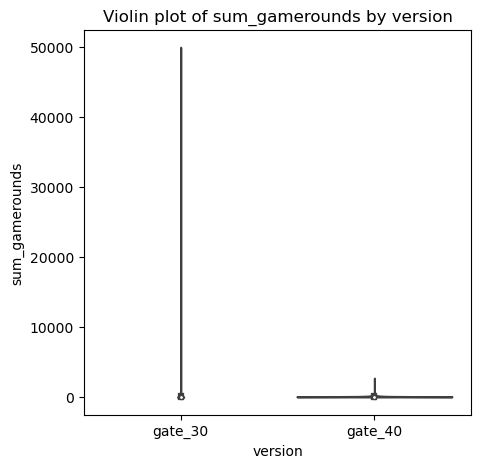

In [35]:
plt.figure(figsize=(5, 5))
sns.violinplot(x='version', y='sum_gamerounds', data=df)
plt.title('Violin plot of sum_gamerounds by version')
plt.show()

In [ ]:
# A violin plot combines aspects of a boxplot and a kernel density plot to provide insights into the distribution of data.

C:\Users\82108\AppData\Local\Temp\ipykernel_17620\752187430.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['version'] == 'gate_30']['sum_gamerounds'], label='Version: gate_30', color="coral", shade=True)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\82108\AppData\Local\Temp\ipykernel_17620\752187430.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['version'] == 'gate_40']['sum_gamerounds'], label='Version: gate_40', color="blue", shade=True)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldco

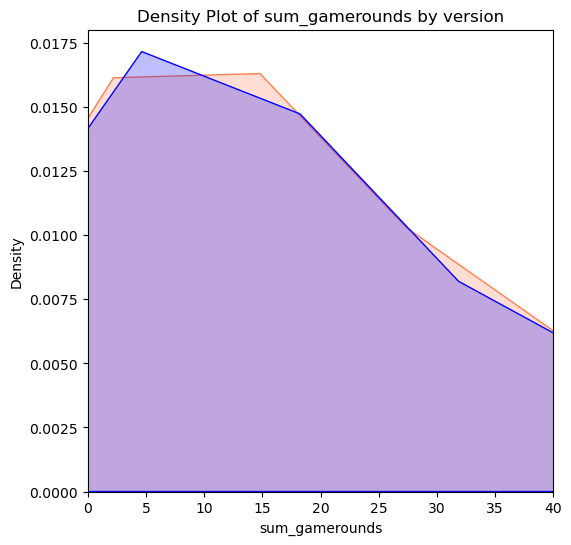

In [84]:
plt.figure(figsize=(6, 6))
sns.kdeplot(df[df['version'] == 'gate_30']['sum_gamerounds'], label='Version: gate_30', color="coral", shade=True)
sns.kdeplot(df[df['version'] == 'gate_40']['sum_gamerounds'], label='Version: gate_40', color="blue", shade=True)
plt.title('Density Plot of sum_gamerounds by version')
plt.xlim(0,40)
plt.show()

C:\Users\82108\AppData\Local\Temp\ipykernel_17620\3642246971.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['ret_01'] == 1]['sum_gamerounds'], label='Version: gate_30', color="coral", shade=True)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\82108\AppData\Local\Temp\ipykernel_17620\3642246971.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['ret_01'] == 0]['sum_gamerounds'], label='Version: gate_40', color="blue", shade=True)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: Futu

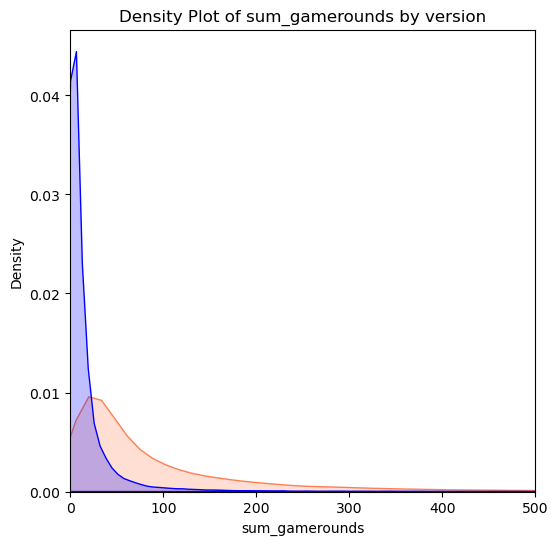

In [82]:
plt.figure(figsize=(6, 6))
sns.kdeplot(df[df['ret_01'] == 1]['sum_gamerounds'], label='Version: gate_30', color="coral", shade=True)
sns.kdeplot(df[df['ret_01'] == 0]['sum_gamerounds'], label='Version: gate_40', color="blue", shade=True)
plt.title('Density Plot of sum_gamerounds by version')
plt.xlim(0,500)
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


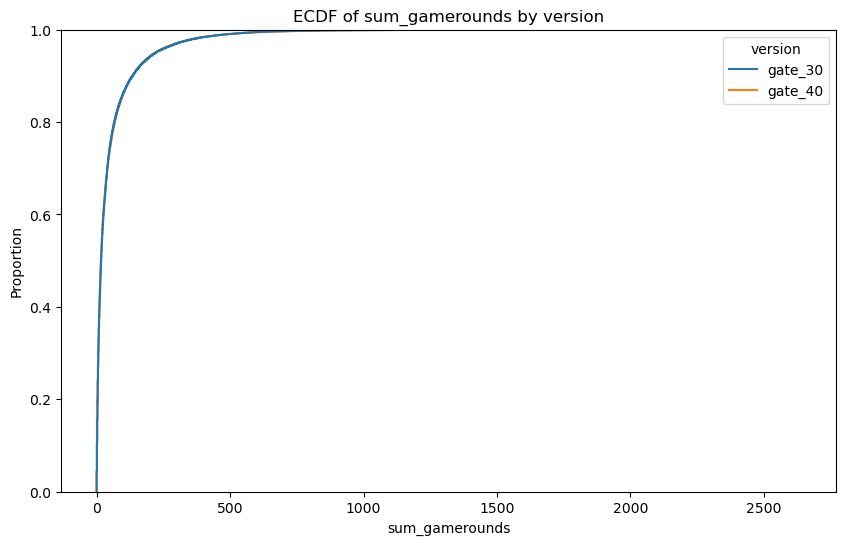

In [71]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df, x='sum_gamerounds', hue='version')
plt.title('ECDF of sum_gamerounds by version')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


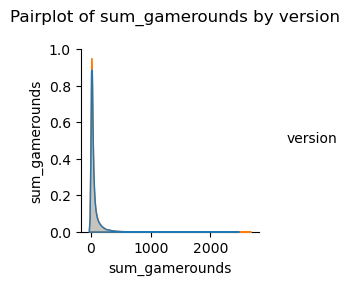

In [120]:
sns.pairplot(df, hue='version', vars=['sum_gamerounds'])
plt.suptitle('Pairplot of sum_gamerounds by version', y=1.1)
plt.show()

In [108]:
df.groupby('version')['sum_gamerounds'].agg(['count', 'mean', 'std', 'min', 'max'])

,count,mean,std,min,max
version,,,,,
gate_30,44700,2.888910,1.498278,0.0,10.816874
gate_40,45489,2.870742,1.509153,0.0,7.878913


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


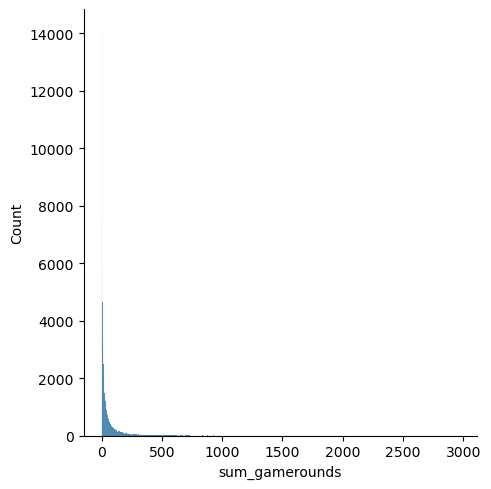

In [46]:
sns.displot(
    df["sum_gamerounds"],   
    stat= "count"  
)

<Axes: xlabel='version', ylabel='sum_gamerounds'>

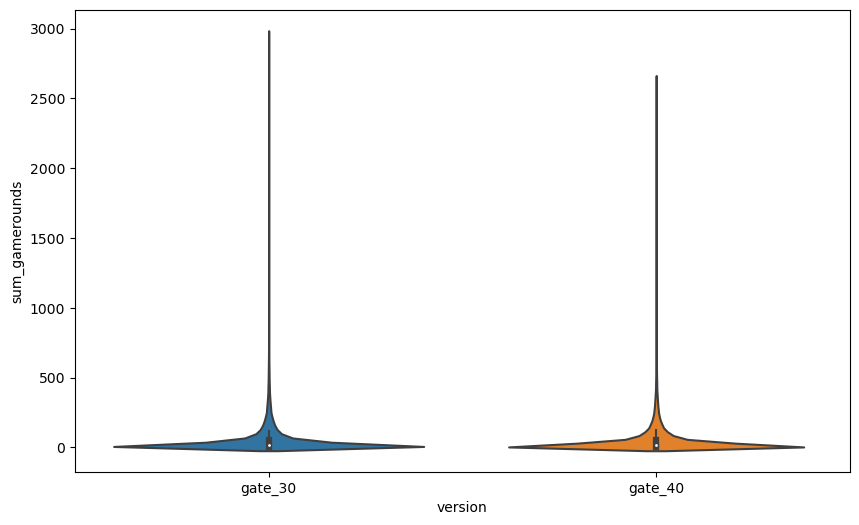

In [47]:
fig = plt.figure(figsize=(10,6))
sns.violinplot(
    data=df,
    x="version",
    y="sum_gamerounds",
)

In [49]:
df.groupby("sum_gamerounds")["userid"].count()

sum_gamerounds
0       3994
1       5538
2       4606
3       3958
4       3629
        ... 
2251       1
2294       1
2438       1
2640       1
2961       1
Name: userid, Length: 941, dtype: int64

In [50]:
 max(df['sum_gamerounds'])

2961

In [51]:
df.sort_values(
    by=["sum_gamerounds"], 
    ascending=False
)

,userid,version,sum_gamerounds,retention_1,retention_7,ret_01,ret_07,ret_sum
7912,871500,gate_30,2961,True,True,1,1,2
29417,3271615,gate_40,2640,True,False,1,0,1
43671,4832608,gate_30,2438,True,True,1,1,2
48188,5346171,gate_40,2294,True,True,1,1,2
46344,5133952,gate_30,2251,True,True,1,1,2
...,...,...,...,...,...,...,...,...
59687,6610805,gate_30,0,False,False,0,0,0
23707,2639282,gate_40,0,False,False,0,0,0
59670,6608718,gate_30,0,False,False,0,0,0
59645,6604544,gate_30,0,False,False,0,0,0


In [121]:
# 재접속률 1번 평균
ret_1_ratio= df[["retention_1"]].mean()*100
ret_1_ratio

retention_1    44.52095
dtype: float64

In [123]:
# 재접속률 7번 평균 
ret_7_ratio = df[["retention_7"]].mean()*100
ret_7_ratio

retention_7    18.606482
dtype: float64

In [161]:
version_stat = df.groupby("version").agg({"userid":"count", "retention_1":"mean", "retention_7":"mean", "sum_gamerounds":"sum"})
version_stat

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,129134.287713
gate_40,45489,0.442283,0.182000,130587.167874


In [52]:
# 30번이 재접속률이 조금 더 높음
# 하지만 유저수랑 게임 더 많이 한 건 40번임

In [109]:
# 플레이 0인 경우 빈도수
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

In [135]:
# 플레이 0인 경우 확률
df[df["sum_gamerounds"]== 0]["userid"].count() / len(df)* 100

4.42847797403231

In [95]:
df[(df["version"]== "gate_30") & (df["ret_sum"] == 1)]["userid"].count() 

15183

In [54]:
# 30스테이지 & 접속 1, 7 둘다
df[(df["version"]== "gate_30") & (df["ret_sum"] == 2)]["userid"].count() / len(df)* 100

7.402315163879895

In [175]:
# 30스테이지 & 접속 1 
df[(df["version"]== "gate_30") & (df["ret_01"] == 1) & (df["ret_07"] == 0)]["userid"].count() / len(df)* 100

14.8114473261113

In [176]:
# 30스테이지 & 접속 7
df[(df["version"]== "gate_30") & (df["ret_01"] == 0) & (df["ret_07"] == 1)]["userid"].count() / len(df)* 100

2.0235732422632973

In [136]:
# 0번 플레이 & 30스테이지 
df[(df["sum_gamerounds"]== 0) & (df["version"] == "gate_30")]["userid"].count() / len(df)* 100

2.1477120269655945

In [174]:
# 40스테이지 & 접속 1, 7 둘다
df[(df["version"]== "gate_40") & (df["ret_sum"] == 2)]["userid"].count() / len(df)* 100

7.213900007761651

In [177]:
# 40스테이지 & 접속 1
df[(df["version"]== "gate_40") & (df["ret_01"] == 1) & (df["ret_07"] == 0)]["userid"].count() / len(df)* 100

15.094193176400147

In [178]:
# 40스테이지 & 접속 7
df[(df["version"]== "gate_40") & (df["ret_01"] == 0) & (df["ret_07"] == 1)]["userid"].count() / len(df)* 100

1.965915264949494

In [60]:
# 0번 플레이 & 40스테이지 
df[(df["sum_gamerounds"]== 0) & (df["version"] == "gate_40")]["userid"].count() / len(df)* 100

2.280791236084623

# t-test

### Q: t-test를 이용하여 gate_30 그룹과 gate_40 그룹의 플레이 라운드 수의 평균이 같은지, 다른지 검정하세요.

귀무가설: gate_30 그룹 평균과 gate_40 그룹 평균은 같다.

대립가설: gate_30 그룹 평균과 gate_40 그룹 평균은 다르다.

In [101]:
df.groupby(["version"])[["sum_gamerounds"]].mean()

,sum_gamerounds
version,
gate_30,51.277015
gate_40,51.298776


<Axes: xlabel='version'>

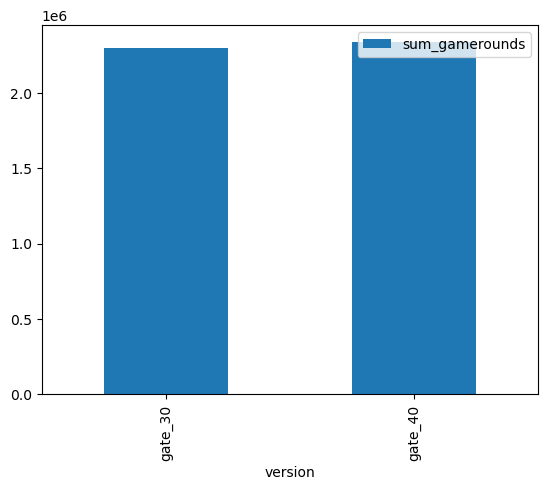

In [214]:
sum_gamerounds = df.groupby(["version"])[["sum_gamerounds"]].sum()
sum_gamerounds.plot(kind="bar")

<Axes: xlabel='version'>

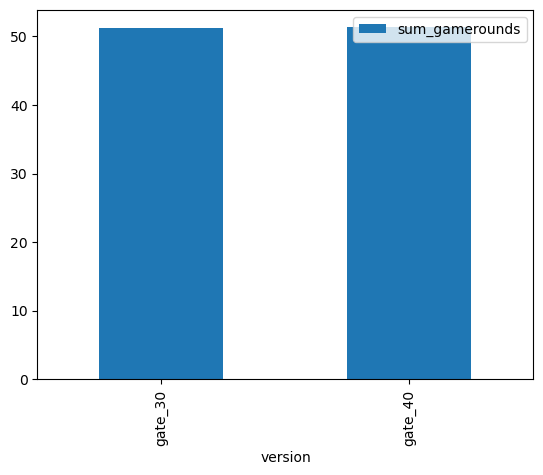

In [138]:
mean_gamerounds = df.groupby(["version"])[["sum_gamerounds"]].mean()
mean_gamerounds.plot(kind="bar")

In [134]:
# 등분산 검정

In [135]:
from scipy import stats
test_names = ["sum_gamerounds"]

gate_30_sum = df[df["version"] == "gate_30"][["sum_gamerounds"]]
gate_40_sum = df[df["version"] == "gate_40"][["sum_gamerounds"]]

In [136]:
for test_name in test_names:
    # print(stats.levene(male_scores[test_name], female_scores[test_name]))
    statistic, pvalue = stats.levene(gate_30_sum[test_name], gate_40_sum[test_name])
    if pvalue > 0.05:
        print(f"{test_name} pvalue: {pvalue} 등분산 가정 만족")
    else:
        print(f"{test_name} pvalue: {pvalue} 이분산 가정 만족")

sum_gamerounds pvalue: 0.7840494387892463 등분산 가정 만족


In [140]:
df

,userid,version,sum_gamerounds,retention_1,retention_7,ret_01,ret_07,ret_sum
0,116,gate_30,3,False,False,0,0,0
1,337,gate_30,38,True,False,1,0,1
2,377,gate_40,165,True,False,1,0,1
3,483,gate_40,1,False,False,0,0,0
4,488,gate_40,179,True,True,1,1,2
...,...,...,...,...,...,...,...,...
90184,9999441,gate_40,97,True,False,1,0,1
90185,9999479,gate_40,30,False,False,0,0,0
90186,9999710,gate_30,28,True,False,1,0,1
90187,9999768,gate_40,51,True,False,1,0,1


In [137]:
# 양측검정 ttest

In [138]:
for test_name in test_names:
    t_statistic, pvalue = stats.ttest_ind(     
    a = gate_30_sum[test_name],
    b = gate_40_sum[test_name],
        alternative = "two-sided",  
        equal_var = True             
    )
    if pvalue < 0.05:
        print(test_name, pvalue, "귀무가설 기각")
    else:
        print(test_name, pvalue, "귀무가설 기각 불가")

sum_gamerounds 0.9494739458256001 귀무가설 기각 불가


In [107]:
# 1
for test_name in test_names:
    t_statistic, pvalue = stats.ttest_ind(     
    a = gate_30_sum[test_name],
    b = gate_40_sum[test_name],
        alternative = "two-sided",  
        equal_var = True             
    )
    if pvalue < 0.05:
        print(test_name, pvalue, "귀무가설 기각")
    else:
        print(test_name, pvalue, "귀무가설 기각 불가")


sum_gamerounds 0.9745019594672731 귀무가설 기각 불가


gate_30 평균과 gate_40 평균은 같다



In [108]:
# 단측검정 ttest

In [141]:
for test_name in test_names:
    t_statistic, pvalue = stats.ttest_ind(     
    a = gate_30_sum[test_name],
    b = gate_40_sum[test_name],
        alternative = "greater",    # 단측검정 (a > b)
        equal_var = True           
    )
    if pvalue < 0.05:
        print(test_name, pvalue, "귀무가설 기각")
    else:
        print(test_name, pvalue, "귀무가설 기각 불가")

sum_gamerounds 0.47473697291280004 귀무가설 기각 불가


In [109]:
for test_name in test_names:
    t_statistic, pvalue = stats.ttest_ind(     
    a = gate_30_sum[test_name],
    b = gate_40_sum[test_name],
        alternative = "greater",    # 단측검정 (a > b)
        equal_var = True           
    )
    if pvalue < 0.05:
        print(test_name, pvalue, "귀무가설 기각")
    else:
        print(test_name, pvalue, "귀무가설 기각 불가")

sum_gamerounds 0.5127490202663634 귀무가설 기각 불가


In [142]:
from scipy import stats

gate_30_sum = df[df["version"] == "gate_30"]["sum_gamerounds"]
gate_40_sum = df[df["version"] == "gate_40"]["sum_gamerounds"]
test_names = ["sum_gamerounds"]

In [143]:
_, p_value_levene = stats.levene(gate_30_sum, gate_40_sum)
if p_value_levene > 0.05:
    print(f"p-value: {p_value_levene}, 등분산 가정 만족")
else:
    print(f"p-value: {p_value_levene}, 이분산 가정 만족")

p-value: 0.7840494387892463, 등분산 가정 만족


In [144]:

# 양측 t-test
t_statistic, p_value = stats.ttest_ind(
    a=gate_30_sum,
    b=gate_40_sum,
    # 양측
    alternative="two-sided",
    equal_var=False
)

print(f"t통계량: {t_statistic}, p-value: {p_value}")
print(f"귀무 가설 기각: {p_value < 0.05}")


t통계량: 0.06337426312892294, p-value: 0.9494686215464458
귀무 가설 기각: False


In [145]:
t_statistic, p_value = stats.ttest_ind(
    a=gate_30_sum,
    b=gate_40_sum,
    # 단측
    alternative="greater",
    equal_var=False
)

print(f"t통계량: {t_statistic}, p-value: {p_value}")
print(f"귀무 가설 기각: {p_value < 0.05}")

t통계량: 0.06337426312892294, p-value: 0.4747343107732229
귀무 가설 기각: False


# gate_30 평균과 gate_40 평균은 같다

# 두 집단의 평균이 통계적으로 유의미한 차이가 없음 

< 인사이트 >

게임의 첫 번째 게이트를 레벨 30에서 레벨 40으로 이동시켜도 평균 게임라운드에 큰 변화가 없다:

두 그룹 간의 sum_gamerounds 평균이 유의한 차이가 없다는 것은, 새로운 게이트 위치로 인해 전반적인 게임 플레이량에 큰 영향을 미치지 않았을 가능성이 있습니다.

사용자들이 게임을 이탈하지 않고 유지되었을 가능성:

두 그룹의 게임라운드 평균이 차이가 없다는 것은, 새로운 게이트 위치가 사용자 이탈을 촉진하지 않았거나 사용자들이 계속해서 게임에 참여했을 가능성이 있습니다.

게이트 이동의 긍정적인 효과:

귀무가설이 채택되었더라도, 게이트 이동이 게임 경험에 어떠한 영향을 미치는지를 확인하기 위해 추가 분석이 필요할 수 있습니다. 예를 들어, 다른 지표들이나 부수적인 결과들을 살펴보면서 사용자들의 행동 변화에 대한 미묘한 변화를 찾을 수 있습니다.

더 많은 세분화된 분석이 필요할 수 있음:

다른 변수들에 대한 분석이나 그룹을 세분화하여 살펴볼 수 있습니다. 예를 들어, 사용자의 세부적인 특성에 따라 게이트 이동이 어떻게 영향을 미치는지 확인할 수 있습니다.

In [156]:
# 30스테이지 & 접속 1, 7 둘다
df[(df["version"]== "gate_30") & (df["ret_sum"] == 2)]["sum_gamerounds"].mean() 

183.47026217228463

In [171]:
df[(df["version"]== "gate_40") & (df["ret_01"] == 1) & (df["ret_07"] == 0)]["sum_gamerounds"].mean() 

50.025490340116065

In [173]:
df[(df["version"]== "gate_40") & (df["ret_01"] == 0) & (df["ret_07"] == 1)]["sum_gamerounds"].mean() 

75.26113931190073

In [168]:
df[(df["version"]== "gate_40") & (df["ret_sum"] == 2)]["sum_gamerounds"].mean() 

190.28235474946203

# 카이제곱 검정

### Q: chi_squre test를 이용하여 version과 retention_1이 서로 독립인지 검정하세요.

귀무가설: 두 변수는 독립이다. 즉, 기대 빈도와 관측 빈도는 동일하다.  
대립가설: 두 변수는 독립이 아니다. 즉, 기대 빈도와 관측 빈도는 다르다.  

In [152]:
table = pd.crosstab(df['version'], df["retention_1"])
table

retention_1,False,True
version,,
gate_30,24665,20034
gate_40,25370,20119


In [153]:
from scipy.stats import chi2_contingency

chi2_contingency(table)
chi2_statistics, pvalue, dof, _ = chi2_contingency(table)
# 통계량, pvalue, 자유도

In [154]:
print(f"카이 제곱 통계량 {chi2_statistics}")
print(f"p value: {pvalue}")
print(f"자유도: {dof}")

카이 제곱 통계량 3.169835543170799
p value: 0.07500999897705693
자유도: 1


### p-value가 유의 수준인 0.05보다 커서 귀무가설 채택 -> version과 retention_1 두 변수는 독립이다.

# gate 버전과  1일 뒤 재접속률은 서로에게 아무런 영향을 끼치지 않는다

이 결과는 게임 버전과 첫 날 유지율 간에 강한 관련성이 없다는 것을 시사합니다. 즉, 특정 버전의 게임이 첫 날 유지율에 큰 영향을 미치지 않는 것으로 나타났습니다.

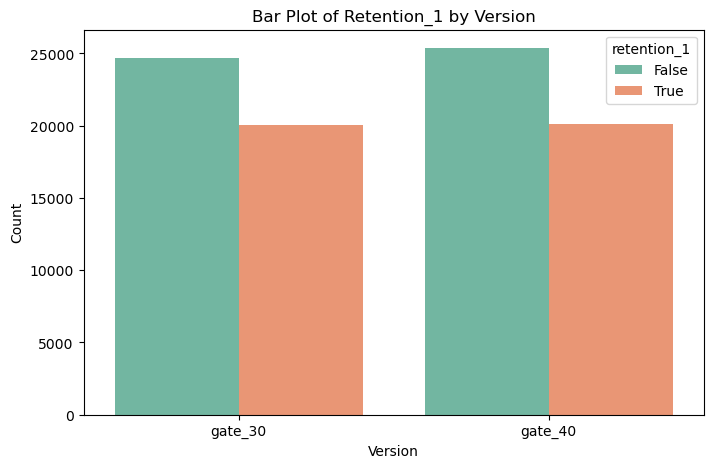

In [125]:
plt.figure(figsize=(8, 5))
sns.countplot(x='version', hue='retention_1', data=df, palette='Set2')
plt.title('Bar Plot of Retention_1 by Version')
plt.xlabel('Version')
plt.ylabel('Count')
plt.show()

### Q: chi_squre test를 이용하여 version과 retention_7이 서로 독립인지 검정하세요.

In [155]:
table = pd.crosstab(df['version'], df["retention_7"])
table

retention_7,False,True
version,,
gate_30,36198,8501
gate_40,37210,8279


In [156]:
chi2_contingency(table)
chi2_statistics, pvalue, dof, _ = chi2_contingency(table)
# 통계량, pvalue, 자유도

In [157]:
print(f"카이 제곱 통계량 {chi2_statistics}")
print(f"p value: {pvalue}")
print(f"자유도: {dof}")

카이 제곱 통계량 9.91527552890567
p value: 0.0016391259678654425
자유도: 1


### p-value가 유의 수준인 0.05보다 작음 -> 귀무가설 기각 -> version과 retention_7 두 변수는 독립이 아니다.

# 7일 뒤 재접속률은 gate 버전과 관련이 있다

version과 일주일 유지율 간에 독립성이 없다는 결과는 게임 버전과 일주일 동안의 유지율 사이에 어떤 관련성이 있을 수 있다는 것을 시사할 수 있습니다.

https://www.statdistributions.com/chisquare/

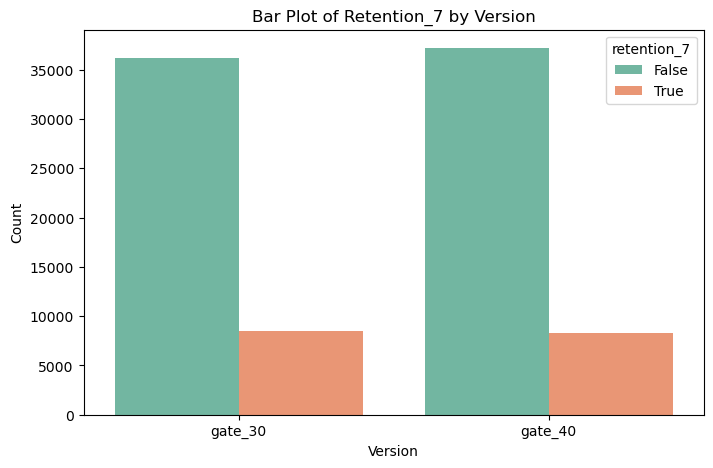

In [179]:
plt.figure(figsize=(8, 5))
sns.countplot(x='version', hue='retention_7', data=df, palette='Set2')
plt.title('Bar Plot of Retention_7 by Version')
plt.xlabel('Version')
plt.ylabel('Count')
plt.show()

< 인사이트 >

게임 버전과 첫 날 유지율 (retention_1) ->

첫 날 유지율은 사용자가 게임을 시작한 직후의 행동을 나타냅니다. 게임 버전과의 독립성은 사용자가 처음 게임을 시작할 때 어떤 버전을 선택하더라도 첫 날 유지율에는 큰 차이가 없다는 것을 의미할 수 있습니다.

게임 버전과 7일 동안의 유지율 (retention_7) ->

게임 버전과 7일 동안의 유지율 간에 관련성이 있다는 결과는 흥미로울 수 있습니다. 이는 게임의 변경 사항이 사용자가 더 오랜 기간 동안 게임을 유지하게 하는 데 영향을 미칠 수 있다는 것을 시사할 수 있습니다.

추가 분석과 설문조사 ->

결과를 더 깊이 이해하기 위해 추가적인 특성이나 사용자 행동과 관련된 변수들을 고려할 수 있습니다. 또한, 사용자들에게 진행된 설문조사나 피드백을 통해 게임 변경 사항이나 버전 간의 선호도에 대한 통찰을 얻을 수 있습니다.

향후 실험 및 모델링 ->

이러한 결과를 기반으로 향후 실험을 진행하거나, 이를 통한 사용자 행동을 예측하는 모델을 구축할 수 있습니다. 게임 버전이나 특정 기능이 사용자 유지율에 미치는 영향을 더 자세히 이해하고 개선하기 위해 추가적인 실험이나 개발을 진행할 수 있습니다.

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

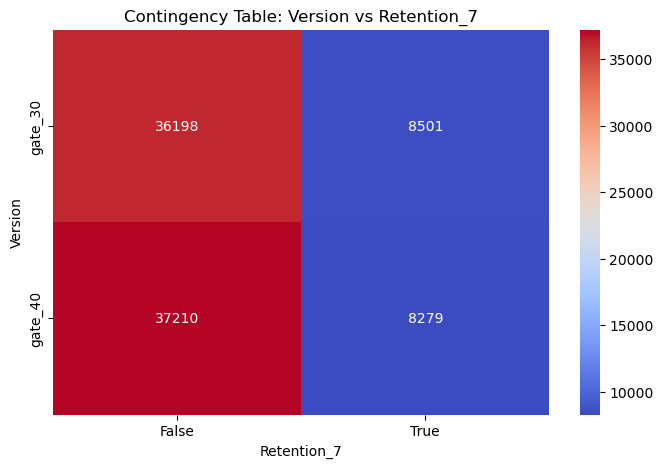

In [207]:
plt.figure(figsize=(8, 5))
sns.heatmap(table, annot=True, cmap='coolwarm', fmt='d', cbar=True)
plt.title('Contingency Table: Version vs Retention_7')
plt.xlabel('Retention_7')
plt.ylabel('Version')
plt.show()

In [208]:
table1 = pd.crosstab(df['version'], df["retention_1"])
table1

retention_1,False,True
version,,
gate_30,24665,20034
gate_40,25370,20119


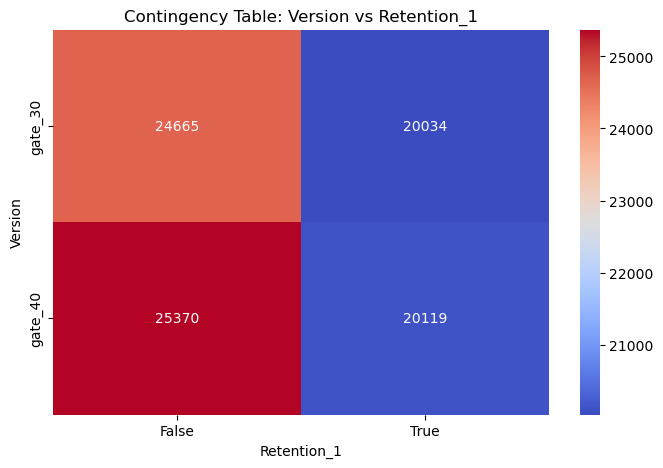

In [213]:
# 분포 시각화
plt.figure(figsize=(8, 5))
sns.heatmap(table1, annot=True, cmap='coolwarm', fmt='d', cbar=True)
plt.title('Contingency Table: Version vs Retention_1')
plt.xlabel('Retention_1')
plt.ylabel('Version')
plt.show()

# 가설 세워보기

## 1. 게이트 이동과 사용자 유지율

가설: "게이트를 레벨 30에서 레벨 40으로 이동하면 사용자의 일주일 동안의 유지율이 감소할 것이다."

분석 방향: 게이트 이동 전후의 유지율을 비교하여 통계적으로 유의미한 차이가 있는지 확인.

## 2. 게임 버전과 플레이량

가설: "게임의 버전에 따라 플레이어들의 게임 플레이량에 차이가 있을 것이다."

분석 방향: 각 버전별로 플레이량의 분포를 비교하고, 통계적으로 차이가 있는지 확인.

## 3. 플레이 시간과 유지율:

가설: "게임에 더 많은 시간을 투자한 플레이어들은 일주일 동안의 유지율이 더 높을 것이다."

분석 방향: 플레이 시간과 일주일 동안의 유지율 간의 상관관계를 조사.

Box plot을 통해 일주일 동안 유지된 그룹과 이탈한 그룹 간의 sum_gamerounds 분포를 시각적으로 비교.

만약 "더 많은 시간을 투자한 플레이어들은 일주일 동안의 유지율이 더 높을 것"이라는 가설이 맞다면, 일주일 동안 유지된 그룹의 sum_gamerounds의 중앙값 또는 상위 사분위수가 높을 것으로 기대됩니다.

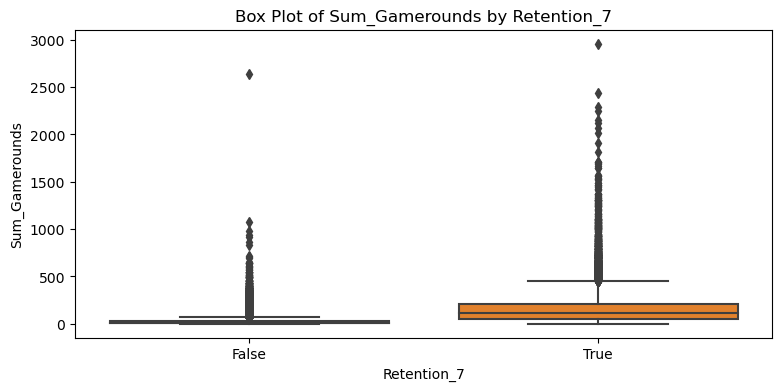

In [221]:
# 3번째 가설 시각화

plt.figure(figsize=(9, 4))
sns.boxplot(x='retention_7', y='sum_gamerounds', data=df)
plt.title('Box Plot of Sum_Gamerounds by Retention_7')
plt.xlabel('Retention_7')
plt.ylabel('Sum_Gamerounds')
plt.show()

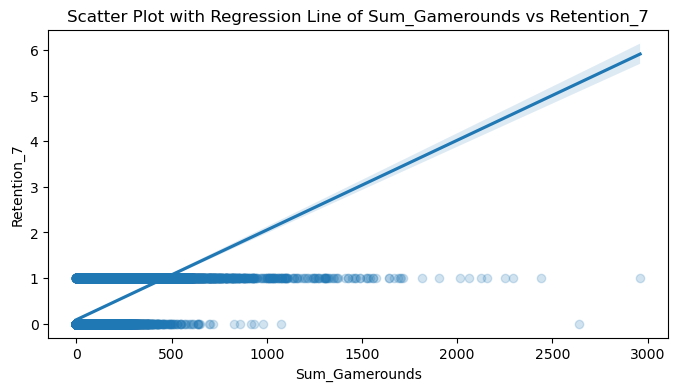

In [53]:
plt.figure(figsize=(8, 4))
sns.regplot(x='sum_gamerounds', y='ret_07', data=df, scatter_kws={'alpha':0.2})
plt.title('Scatter Plot with Regression Line of Sum_Gamerounds vs Retention_7')
plt.xlabel('Sum_Gamerounds')
plt.ylabel('Retention_7')
plt.show()

이 코드는 'sum_gamerounds'를 x축으로, 'retention_7'을 y축으로 하는 산점도를 생성하며, scatter plot에 회귀선을 추가합니다. 각 점은 사용자의 게임 플레이량과 7일 유지율을 나타내며, 회귀선은 이 두 변수 간의 선형 관계를 시각화합니다.

만약 산점도와 회귀선이 상승하는 경향을 보인다면, 게임을 더 많이 플레이한 사용자들이 더 높은 7일 유지율을 가질 가능성이 있습니다.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x800 with 0 Axes>

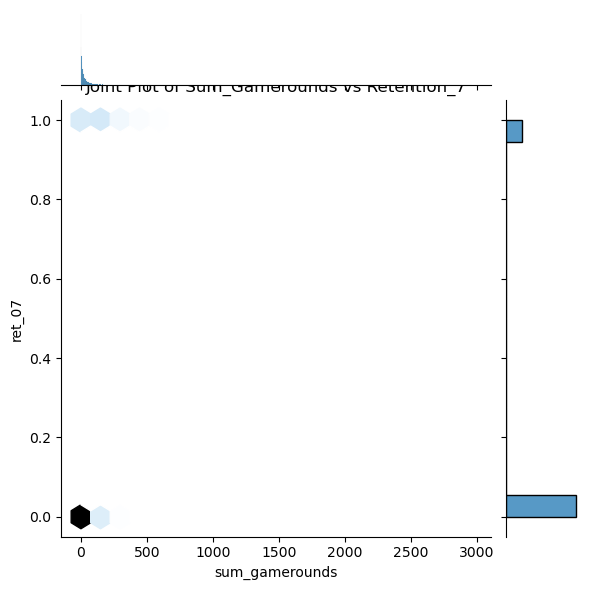

In [24]:
plt.figure(figsize=(10, 8))
sns.jointplot(x='sum_gamerounds', y='ret_07', data=df, kind='hex', gridsize=20)
plt.title('Joint Plot of Sum_Gamerounds vs Retention_7')
plt.show()

In [77]:
df = df[df['sum_gamerounds'] < 40000]

In [78]:
df

,userid,version,sum_gamerounds,retention_1,retention_7,ret_01,ret_07,ret_sum
0,116,gate_30,3,False,False,0,0,0
1,337,gate_30,38,True,False,1,0,1
2,377,gate_40,165,True,False,1,0,1
3,483,gate_40,1,False,False,0,0,0
4,488,gate_40,179,True,True,1,1,2
...,...,...,...,...,...,...,...,...
90184,9999441,gate_40,97,True,False,1,0,1
90185,9999479,gate_40,30,False,False,0,0,0
90186,9999710,gate_30,28,True,False,1,0,1
90187,9999768,gate_40,51,True,False,1,0,1


In [146]:
from scipy import stats

group_1 = df[df['retention_7'] == 0]["sum_gamerounds"]
group_0 = df[df['retention_7'] == 1]["sum_gamerounds"]
test_names = ["sum_gamerounds"]
#group_1 = df[df['ret_07'] == 1][["sum_gamerounds"]]
#group_0 = df[df['ret_07'] == 0][["sum_gamerounds"]]

In [147]:
_, p_value_levene = stats.levene(group_1, group_0)
if p_value_levene > 0.05:
    print(f"p-value: {p_value_levene}, 등분산 가정 만족")
else:
    print(f"p-value: {p_value_levene}, 이분산 가정 만족")

p-value: 0.0, 이분산 가정 만족


In [148]:

# 양측 t-test
t_statistic, p_value = stats.ttest_ind(
    a=group_1,
    b=group_0,
    # 양측
    alternative="two-sided",
    equal_var=False
)

print(f"t통계량: {t_statistic}, p-value: {p_value}")
print(f"귀무 가설 기각: {p_value < 0.05}")


t통계량: -97.10579268070096, p-value: 0.0
귀무 가설 기각: True


In [149]:

# 단측 t-test
t_statistic, p_value = stats.ttest_ind(
    a=group_1,
    b=group_0,
    # 단측
    alternative="greater",
    equal_var=False
)

print(f"t통계량: {t_statistic}, p-value: {p_value}")
print(f"귀무 가설 기각: {p_value < 0.05}")

t통계량: -97.10579268070096, p-value: 1.0
귀무 가설 기각: False


In [92]:
# for test_name in test_names:
#     statistic, pvalue = stats.levene(group_1[test_name], group_0[test_name])
#     if pvalue > 0.05:
#         print(f"{test_names} pvalue: {pvalue} 등분산 가정 만족")
#     else:
#         print(f"{test_names} pvalue: {pvalue} 이분산 가정 만족")

In [93]:
# # 양측
# for test_name in test_names:
#     t_statistic, pvalue = stats.ttest_ind(     
#     a = group_1[test_name],
#     b = group_0[test_name],
#         alternative = "two-sided",  
#         equal_var = False             
#     )
#     if pvalue < 0.05:
#         print(test_name, t_statistic, pvalue, "귀무가설 기각")
#     else:
#         print(test_name, pvalue, "귀무가설 기각 불가")


In [94]:
# for test_name in test_names:
#     t_statistic, pvalue = stats.ttest_ind(     
#     a = group_1[test_name],
#     b = group_0[test_name],
#         alternative = "greater",    # 단측검정 (a > b)
#         equal_var = False           
#     )
#     if pvalue < 0.05:
#         print(test_name,t_statistic, pvalue, "귀무가설 기각")
#     else:
#         print(test_name, pvalue, "귀무가설 기각 불가")

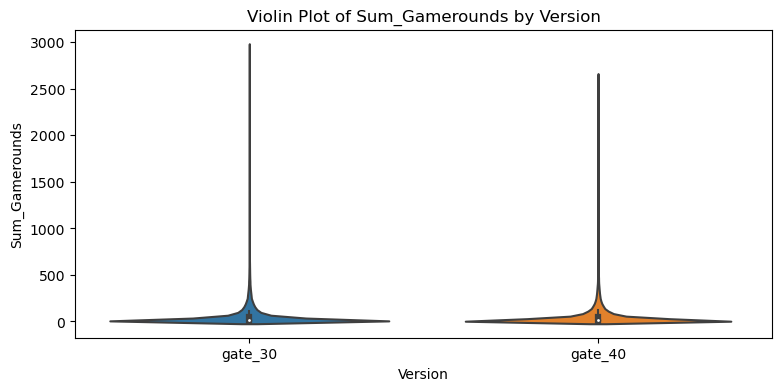

In [224]:
# 2번째 가설 시각화

plt.figure(figsize=(9, 4))
sns.violinplot(x='version', y='sum_gamerounds', data=df)
plt.title('Violin Plot of Sum_Gamerounds by Version')
plt.xlabel('Version')
plt.ylabel('Sum_Gamerounds')
plt.show()

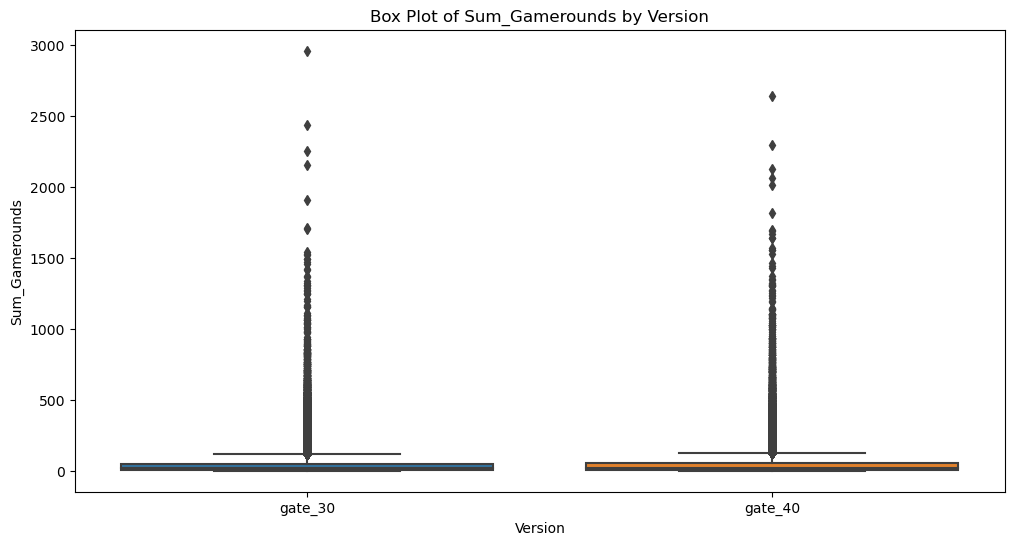

In [225]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.title('Box Plot of Sum_Gamerounds by Version')
plt.xlabel('Version')
plt.ylabel('Sum_Gamerounds')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


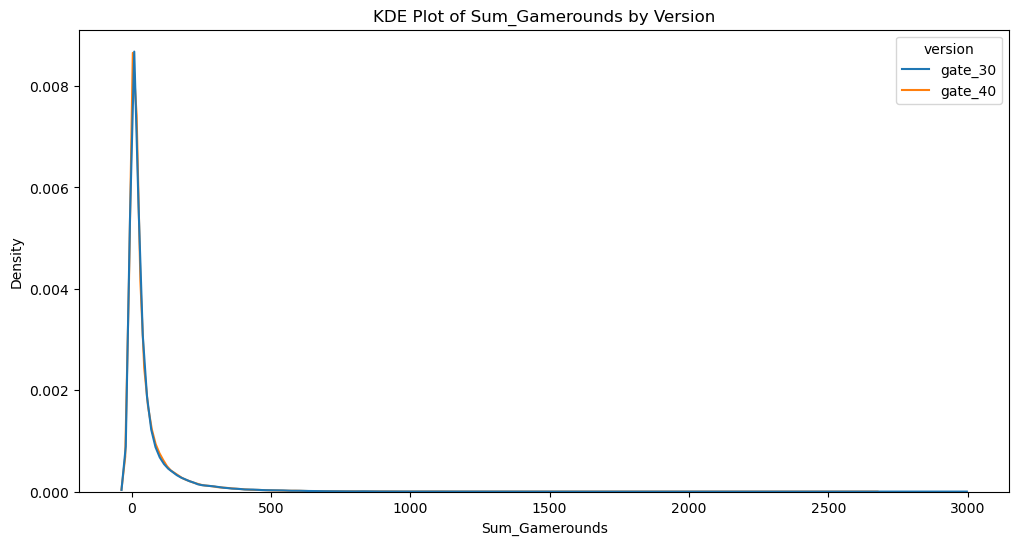

In [227]:
# 2번째 가설 시각화

plt.figure(figsize=(12, 6))
sns.kdeplot(x='sum_gamerounds', hue='version', data=df, fill=False)
plt.title('KDE Plot of Sum_Gamerounds by Version')
plt.xlabel('Sum_Gamerounds')
plt.show()

각 버전별로 플레이어들의 게임 플레이량이 어떻게 다른지 비교할 수 있습니다. Box plot은 중앙값과 분포의 범위를, Violin plot은 분포의 형태를, KDE plot은 분포의 밀도를 확인하는 데 도움이 됩니다.

In [230]:
# 1번째 가설 시각화
mean_retention_by_gate = df.groupby('version')['retention_7'].mean().reset_index()

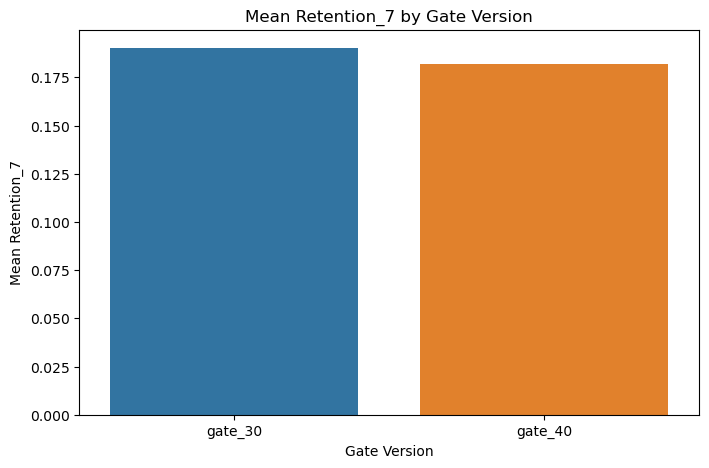

In [231]:
plt.figure(figsize=(8, 5))
sns.barplot(x='version', y='retention_7', data=mean_retention_by_gate)
plt.title('Mean Retention_7 by Gate Version')
plt.xlabel('Gate Version')
plt.ylabel('Mean Retention_7')
plt.show()

C:\Users\82108\AppData\Local\Temp\ipykernel_17620\3507101603.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x='version', y='retention_7', data=df, ci='sd')


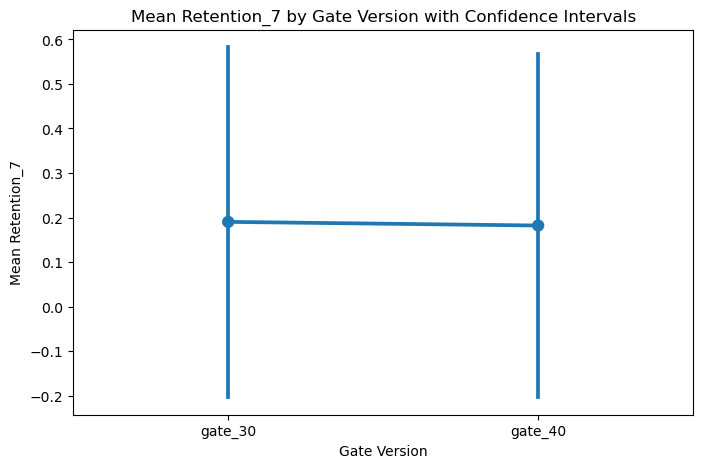

In [228]:
# 1번째 가설 시각화
plt.figure(figsize=(8, 5))
sns.pointplot(x='version', y='retention_7', data=df, ci='sd')
plt.title('Mean Retention_7 by Gate Version with Confidence Intervals')
plt.xlabel('Gate Version')
plt.ylabel('Mean Retention_7')
plt.show()

C:\Users\82108\AppData\Local\Temp\ipykernel_17620\3162890407.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x='version', y='retention_1', data=df, ci='sd')


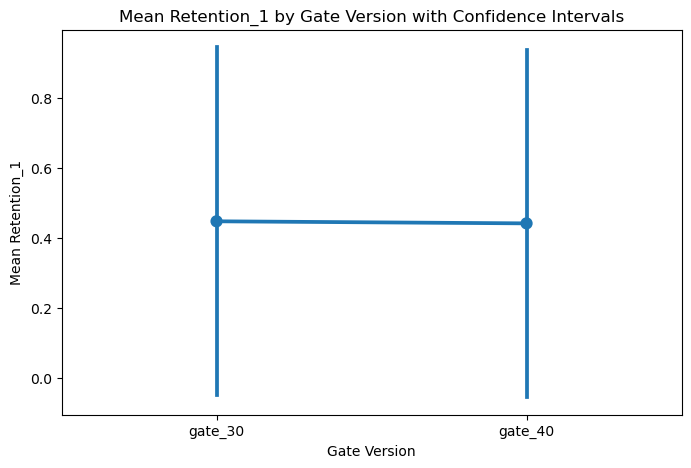

In [229]:
plt.figure(figsize=(8, 5))
sns.pointplot(x='version', y='retention_1', data=df, ci='sd')
plt.title('Mean Retention_1 by Gate Version with Confidence Intervals')
plt.xlabel('Gate Version')
plt.ylabel('Mean Retention_1')
plt.show()

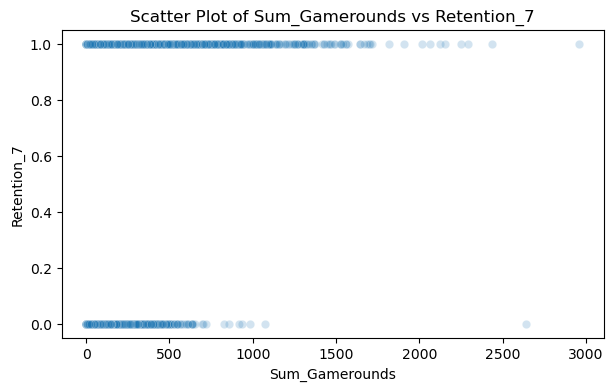

In [219]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x='sum_gamerounds', y='retention_7', data=df, alpha=0.2)
plt.title('Scatter Plot of Sum_Gamerounds vs Retention_7')
plt.xlabel('Sum_Gamerounds')
plt.ylabel('Retention_7')
plt.show()